In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 230
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  ZK75TX1R_12_44_27
NN-MODEL FILENAME:  ./models/ZK75TX1R_12_44_27_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 20
NO_OF_EPISODES = 200
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  20
Number of EPISODES per NODE 200


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000

In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  4.5
P_VEL_ABS_MIN = -4.5

LENGTH_ABS_MAX = 0.8
LENGTH_ABS_MIN = 0.2

In [14]:
# SET GRANULARITY
LO_GRAIN = 15
HI_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  15


In [15]:
def mp_node_run(node_id, boundary):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.5 + (1.5 - 0.5) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
        
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_ABS_MIN, LENGTH_ABS_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################

    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
    my_QFILE   = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(my_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , LO_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR

    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.05,0.05)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
#                                                                          my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.1, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.1, LENGTH_ABS_MAX)
    ###############################################

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

 # SET STATE VALUE BORDERS
###############################################
[C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
 C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
###############################################

# CREATE STATE COMBINATIONS
###############################################

init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
###############################################

# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# for node_id in range(NO_OF_NODES):
node_QFILE = './Q_NPY/' + RNDM_STRING +  'QFILE' + ".npy"
np.save(node_QFILE, init_q_table)
#############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES

peak memory: 5613.21 MiB, increment: 5007.07 MiB
Quantization TIME:  0.05 minutes




ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 111
REAL TIME TO GENERATE 59691 EXPERIENCES:0:00:01.656521


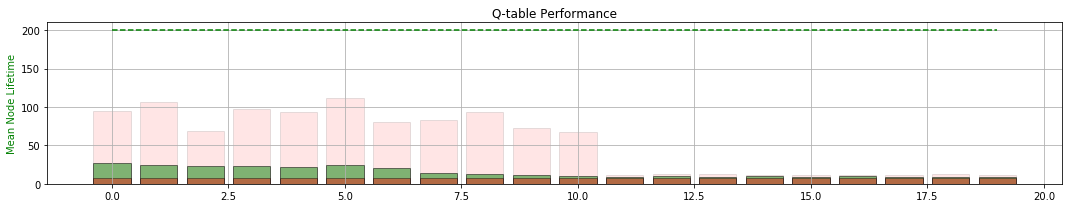

GOOD MEMORY COUNTER:  55691
BAD MEMORY COUNTER:  4000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  57.95
Validating... MEAN TIME:  120.695
Validating... MEAN TIME:  191.47
Validating... MEAN TIME:  199.02
Validating... MEAN TIME:  185.63
TRAINING TIME:0:00:39.751063


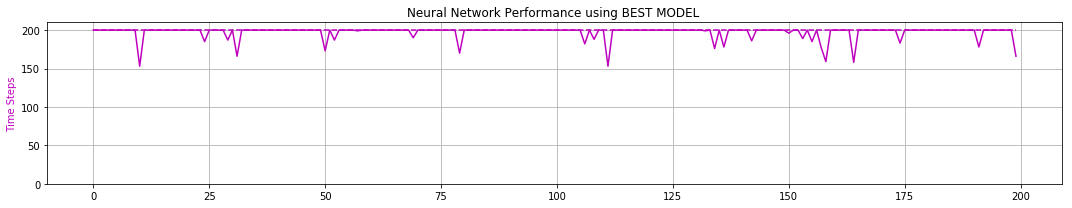

0 -max- [ 0.338  1.996  0.209  1.059  0.325]
0 -min- [-0.051 -0.241 -0.209 -2.945  0.225]

1 -max- [ 0.286  1.918  0.209  0.922  0.350]
1 -min- [-0.050 -0.218 -0.209 -2.949  0.251]

2 -max- [ 0.307  2.174  0.209  0.812  0.375]
2 -min- [-0.050 -0.202 -0.209 -2.969  0.278]

3 -max- [ 0.848  2.514  0.208  0.787  0.399]
3 -min- [-0.050 -0.207 -0.209 -2.979  0.300]

4 -max- [ 0.803  2.287  0.209  1.098  0.424]
4 -min- [-0.050 -0.214 -0.209 -2.930  0.326]

5 -max- [ 0.463  2.120  0.209  0.921  0.450]
5 -min- [-0.050 -0.402 -0.209 -2.964  0.350]

6 -max- [ 0.577  1.987  0.206  0.877  0.474]
6 -min- [-0.050 -0.219 -0.209 -2.946  0.376]

7 -max- [ 0.472  1.926  0.209  0.860  0.499]
7 -min- [-0.050 -0.208 -0.209 -2.964  0.400]

8 -max- [ 0.867  3.045  0.202  0.964  0.524]
8 -min- [-0.050 -0.218 -0.209 -3.101  0.425]

9 -max- [ 0.388  1.990  0.205  0.913  0.549]
9 -min- [-0.051 -0.238 -0.209 -2.965  0.451]

10 -max- [ 0.282  1.969  0.204  0.858  0.575]
10 -min- [-0.050 -0.186 -0.209 -2.969  0.476

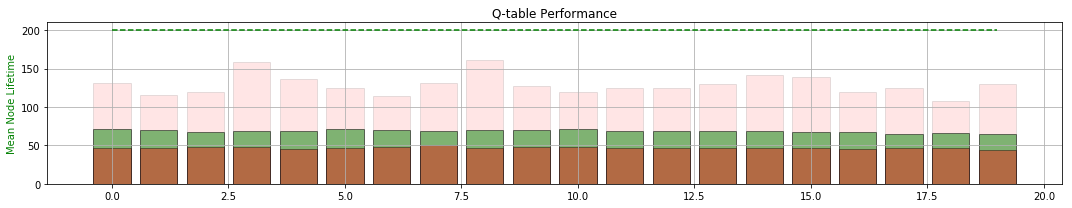

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  139.1
Validating... MEAN TIME:  116.735
Validating... MEAN TIME:  70.245
Validating... MEAN TIME:  52.995
Validating... MEAN TIME:  81.415
TRAINING TIME:0:00:28.285332


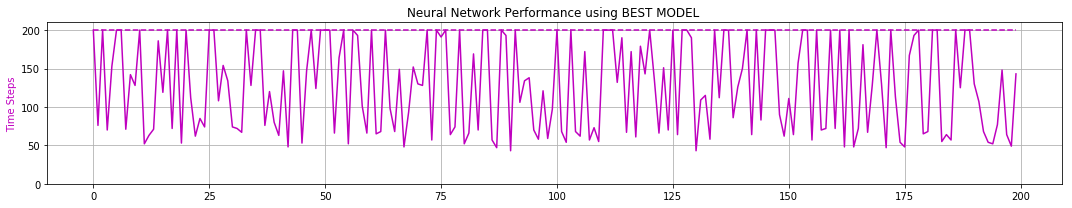

0 -max- [ 0.226  0.574  0.051  0.636  0.324]
0 -min- [-0.711 -1.499 -0.209 -0.786  0.225]

1 -max- [ 0.210  0.595  0.049  0.635  0.350]
1 -min- [-0.656 -1.501 -0.209 -1.180  0.250]

2 -max- [ 0.190  0.779  0.049  0.536  0.375]
2 -min- [-0.793 -1.633 -0.209 -0.984  0.275]

3 -max- [ 0.292  0.551  0.049  0.612  0.400]
3 -min- [-0.638 -1.506 -0.209 -0.822  0.300]

4 -max- [ 0.222  0.566  0.054  0.611  0.424]
4 -min- [-0.734 -1.645 -0.209 -0.828  0.326]

5 -max- [ 0.195  0.582  0.050  0.646  0.449]
5 -min- [-0.603 -1.603 -0.209 -1.069  0.351]

6 -max- [ 0.199  0.569  0.051  0.584  0.475]
6 -min- [-0.585 -1.480 -0.209 -0.859  0.376]

7 -max- [ 0.174  0.580  0.051  0.511  0.500]
7 -min- [-0.693 -1.664 -0.209 -0.837  0.400]

8 -max- [ 0.297  0.597  0.050  0.588  0.525]
8 -min- [-0.698 -1.660 -0.209 -1.020  0.425]

9 -max- [ 0.196  0.432  0.050  0.677  0.549]
9 -min- [-0.698 -1.505 -0.209 -0.792  0.450]

10 -max- [ 0.207  0.540  0.049  0.865  0.575]
10 -min- [-0.733 -1.499 -0.209 -0.832  0.476

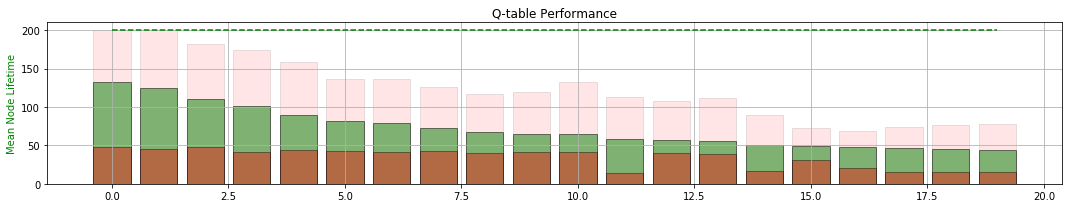

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  71.31
Validating... MEAN TIME:  127.64
Validating... MEAN TIME:  105.9
Validating... MEAN TIME:  189.325
Validating... MEAN TIME:  79.94
TRAINING TIME:0:00:32.498062


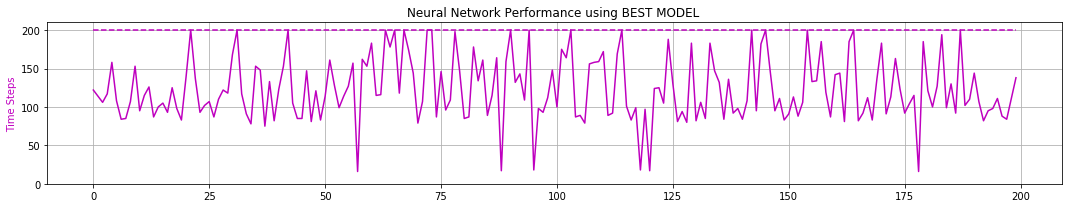

0 -max- [ 0.177  1.778  0.209  2.585  0.325]
0 -min- [-0.997 -2.526 -0.209 -2.586  0.226]

1 -max- [ 0.168  1.724  0.209  2.584  0.350]
1 -min- [-1.099 -2.531 -0.209 -2.498  0.250]

2 -max- [ 0.141  1.769  0.209  2.871  0.374]
2 -min- [-0.975 -2.881 -0.209 -2.564  0.275]

3 -max- [ 0.150  1.774  0.209  2.547  0.400]
3 -min- [-0.966 -2.522 -0.209 -2.568  0.301]

4 -max- [ 0.148  1.603  0.209  2.630  0.425]
4 -min- [-1.042 -2.885 -0.209 -2.291  0.325]

5 -max- [ 0.163  1.778  0.209  2.629  0.450]
5 -min- [-1.011 -2.856 -0.209 -2.576  0.350]

6 -max- [ 0.136  1.772  0.209  2.917  0.474]
6 -min- [-1.104 -3.268 -0.209 -2.527  0.376]

7 -max- [ 0.123  1.594  0.209  2.599  0.500]
7 -min- [-0.964 -2.852 -0.209 -2.291  0.400]

8 -max- [ 0.142  1.602  0.209  2.546  0.525]
8 -min- [-0.919 -2.860 -0.209 -2.280  0.426]

9 -max- [ 0.137  1.594  0.209  2.557  0.550]
9 -min- [-0.906 -2.836 -0.209 -2.461  0.452]

10 -max- [ 0.152  1.586  0.209  2.620  0.575]
10 -min- [-0.957 -2.843 -0.209 -2.309  0.475

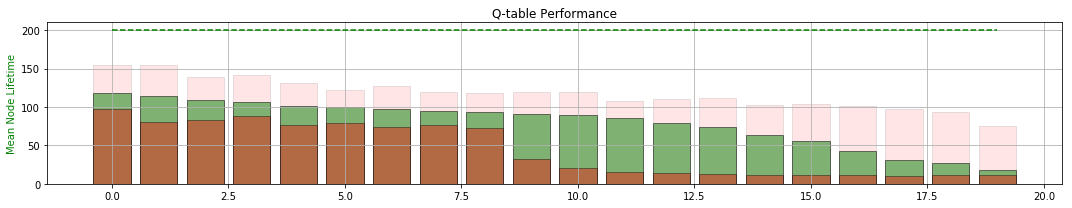

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  176.88
Validating... MEAN TIME:  162.48
Validating... MEAN TIME:  160.5
Validating... MEAN TIME:  167.635
Validating... MEAN TIME:  161.39
TRAINING TIME:0:00:42.659748


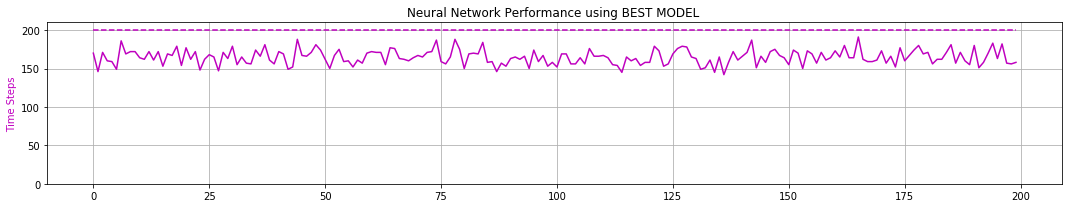

0 -max- [ 0.155  0.742  0.096  1.318  0.325]
0 -min- [-1.845 -2.255 -0.209 -2.238  0.226]

1 -max- [ 0.179  0.811  0.095  1.429  0.350]
1 -min- [-1.870 -2.448 -0.209 -2.095  0.251]

2 -max- [ 0.186  0.643  0.073  1.224  0.375]
2 -min- [-1.822 -2.447 -0.209 -2.117  0.276]

3 -max- [ 0.172  0.758  0.097  1.449  0.400]
3 -min- [-1.785 -2.288 -0.209 -2.127  0.302]

4 -max- [ 0.174  0.809  0.160  1.285  0.424]
4 -min- [-1.836 -2.234 -0.209 -2.122  0.325]

5 -max- [ 0.178  0.821  0.116  1.287  0.450]
5 -min- [-1.816 -2.453 -0.209 -2.210  0.350]

6 -max- [ 0.177  0.787  0.083  1.239  0.474]
6 -min- [-1.905 -2.449 -0.209 -2.274  0.375]

7 -max- [ 0.161  0.814  0.121  1.326  0.499]
7 -min- [-1.832 -2.440 -0.209 -2.305  0.401]

8 -max- [ 0.176  0.827  0.111  1.326  0.525]
8 -min- [-1.868 -2.634 -0.209 -2.246  0.425]

9 -max- [ 0.176  0.816  0.087  1.324  0.550]
9 -min- [-1.840 -2.290 -0.209 -2.254  0.451]

10 -max- [ 0.189  0.994  0.089  1.558  0.575]
10 -min- [-1.842 -2.476 -0.209 -2.194  0.476

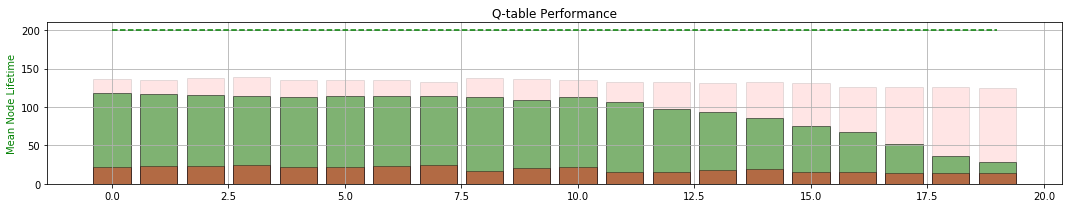

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  138.545
Validating... MEAN TIME:  122.04
Validating... MEAN TIME:  134.57
Validating... MEAN TIME:  132.625
Validating... MEAN TIME:  122.29
TRAINING TIME:0:00:35.898902


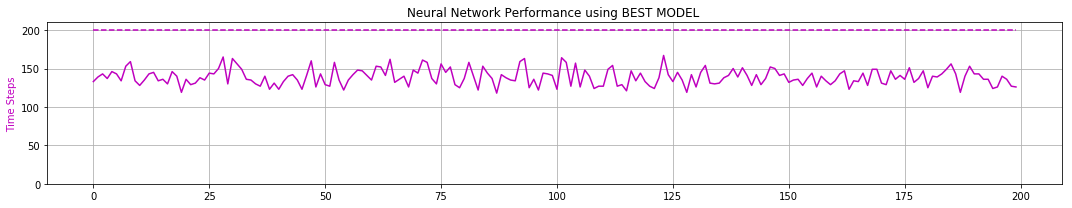

0 -max- [ 0.181  0.814  0.092  1.257  0.325]
0 -min- [-2.400 -2.627 -0.209 -1.293  0.225]

1 -max- [ 0.190  0.775  0.090  1.012  0.349]
1 -min- [-2.400 -2.435 -0.209 -1.281  0.250]

2 -max- [ 0.174  0.786  0.102  1.255  0.375]
2 -min- [-2.400 -2.442 -0.209 -1.325  0.276]

3 -max- [ 0.188  0.813  0.087  1.013  0.400]
3 -min- [-2.400 -2.566 -0.209 -1.317  0.301]

4 -max- [ 0.194  0.809  0.084  1.119  0.424]
4 -min- [-2.400 -2.555 -0.209 -1.280  0.325]

5 -max- [ 0.181  0.821  0.102  1.241  0.450]
5 -min- [-2.399 -2.446 -0.209 -1.424  0.350]

6 -max- [ 0.180  0.787  0.101  0.992  0.474]
6 -min- [-2.400 -2.567 -0.209 -1.341  0.375]

7 -max- [ 0.179  0.978  0.090  1.004  0.499]
7 -min- [-2.400 -2.439 -0.209 -1.439  0.400]

8 -max- [ 0.188  0.827  0.102  1.120  0.525]
8 -min- [-2.400 -2.451 -0.209 -1.476  0.425]

9 -max- [ 0.189  0.804  0.086  1.269  0.550]
9 -min- [-2.400 -2.394 -0.209 -1.481  0.450]

10 -max- [ 0.197  0.812  0.085  1.187  0.573]
10 -min- [-2.400 -2.445 -0.209 -1.424  0.475

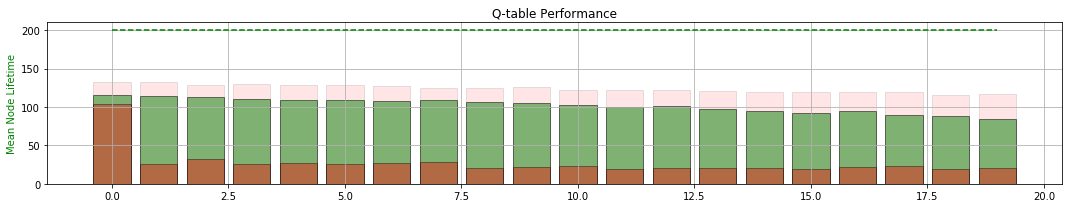

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.595
Validating... MEAN TIME:  101.585
Validating... MEAN TIME:  129.935
Validating... MEAN TIME:  113.32
Validating... MEAN TIME:  112.38
TRAINING TIME:0:00:31.694246


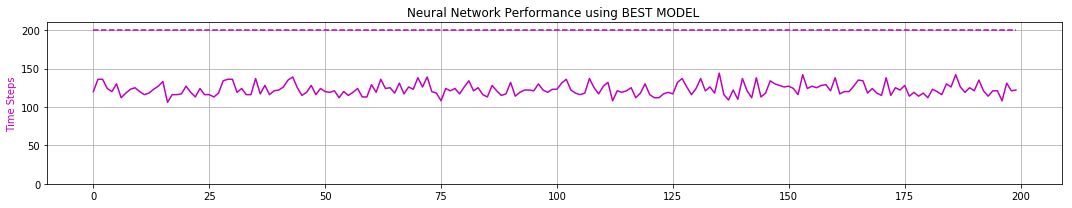

0 -max- [ 0.153  0.626  0.052  0.952  0.324]
0 -min- [-2.400 -2.619 -0.207 -0.991  0.225]

1 -max- [ 0.163  0.824  0.049  1.136  0.350]
1 -min- [-2.400 -2.617 -0.209 -1.118  0.250]

2 -max- [ 0.155  0.627  0.049  1.141  0.375]
2 -min- [-2.400 -2.632 -0.209 -1.023  0.275]

3 -max- [ 0.162  0.751  0.049  0.932  0.400]
3 -min- [-2.400 -2.593 -0.209 -1.159  0.301]

4 -max- [ 0.164  0.629  0.050  0.948  0.425]
4 -min- [-2.400 -2.612 -0.209 -1.016  0.325]

5 -max- [ 0.162  0.808  0.050  0.925  0.450]
5 -min- [-2.400 -2.628 -0.209 -1.117  0.352]

6 -max- [ 0.153  0.636  0.051  0.967  0.474]
6 -min- [-2.400 -2.602 -0.209 -1.084  0.375]

7 -max- [ 0.153  0.634  0.051  0.909  0.499]
7 -min- [-2.400 -2.798 -0.209 -1.009  0.400]

8 -max- [ 0.161  0.997  0.050  0.922  0.524]
8 -min- [-2.400 -2.795 -0.209 -1.428  0.426]

9 -max- [ 0.160  0.763  0.050  0.941  0.550]
9 -min- [-2.399 -2.786 -0.209 -1.058  0.451]

10 -max- [ 0.170  0.823  0.049  0.912  0.575]
10 -min- [-2.400 -2.603 -0.209 -1.125  0.476

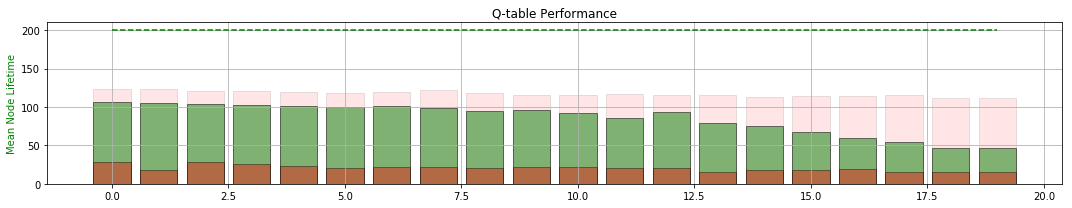

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  27994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  111.485
Validating... MEAN TIME:  107.635
Validating... MEAN TIME:  20.065
Validating... MEAN TIME:  63.725
Validating... MEAN TIME:  123.96
TRAINING TIME:0:00:26.319174


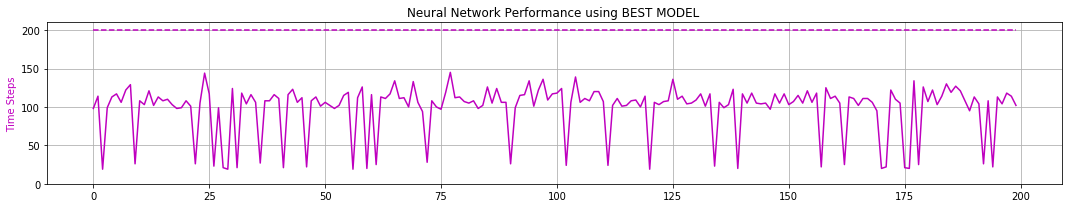

0 -max- [ 0.146  0.813  0.051  1.108  0.325]
0 -min- [-2.400 -2.964 -0.209 -1.104  0.227]

1 -max- [ 0.164  0.631  0.052  1.006  0.350]
1 -min- [-2.400 -2.976 -0.209 -1.067  0.250]

2 -max- [ 0.158  0.633  0.049  0.931  0.375]
2 -min- [-2.400 -2.979 -0.209 -1.073  0.275]

3 -max- [ 0.150  0.633  0.049  1.169  0.400]
3 -min- [-2.399 -2.976 -0.209 -1.167  0.301]

4 -max- [ 0.159  0.736  0.050  0.942  0.424]
4 -min- [-2.400 -2.942 -0.209 -1.167  0.325]

5 -max- [ 0.174  0.827  0.055  1.007  0.450]
5 -min- [-2.400 -2.975 -0.209 -1.321  0.350]

6 -max- [ 0.164  0.822  0.051  0.942  0.475]
6 -min- [-2.399 -2.970 -0.209 -1.204  0.375]

7 -max- [ 0.162  0.828  0.059  0.928  0.500]
7 -min- [-2.399 -2.974 -0.209 -1.211  0.401]

8 -max- [ 0.155  0.731  0.050  1.044  0.525]
8 -min- [-2.400 -2.987 -0.209 -1.192  0.425]

9 -max- [ 0.169  0.763  0.050  0.916  0.550]
9 -min- [-2.400 -2.921 -0.209 -1.173  0.450]

10 -max- [ 0.170  0.957  0.049  1.003  0.575]
10 -min- [-2.400 -2.975 -0.209 -1.412  0.477

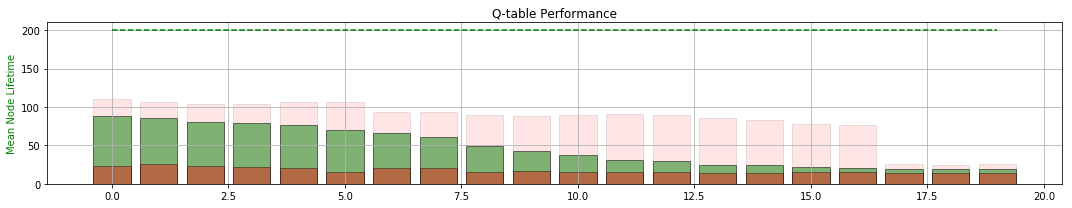

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  31994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  24.165
Validating... MEAN TIME:  122.3
Validating... MEAN TIME:  130.41
Validating... MEAN TIME:  79.6
Validating... MEAN TIME:  30.95
TRAINING TIME:0:00:24.506556


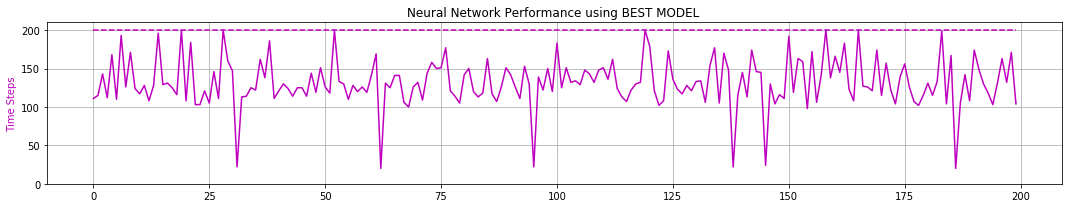

0 -max- [ 0.154  0.634  0.051  1.237  0.325]
0 -min- [-2.153 -2.781 -0.209 -1.112  0.228]

1 -max- [ 0.166  0.784  0.049  1.222  0.349]
1 -min- [-2.186 -2.703 -0.209 -1.187  0.250]

2 -max- [ 0.166  0.800  0.049  1.166  0.374]
2 -min- [-2.359 -2.953 -0.209 -1.099  0.275]

3 -max- [ 0.164  0.815  0.049  1.249  0.400]
3 -min- [-2.017 -2.695 -0.209 -1.112  0.300]

4 -max- [ 0.170  0.632  0.050  1.252  0.424]
4 -min- [-2.111 -2.738 -0.209 -1.068  0.325]

5 -max- [ 0.178  0.827  0.050  1.227  0.450]
5 -min- [-1.995 -2.697 -0.209 -1.186  0.351]

6 -max- [ 0.177  0.788  0.051  0.937  0.474]
6 -min- [-1.809 -2.392 -0.209 -1.152  0.376]

7 -max- [ 0.167  0.769  0.051  0.966  0.500]
7 -min- [-1.687 -2.416 -0.209 -1.166  0.400]

8 -max- [ 0.175  0.825  0.050  0.919  0.525]
8 -min- [-1.643 -2.421 -0.209 -1.361  0.425]

9 -max- [ 0.176  0.807  0.050  0.914  0.550]
9 -min- [-1.681 -2.560 -0.209 -1.201  0.450]

10 -max- [ 0.194  0.811  0.049  0.895  0.575]
10 -min- [-1.688 -2.407 -0.209 -1.245  0.476

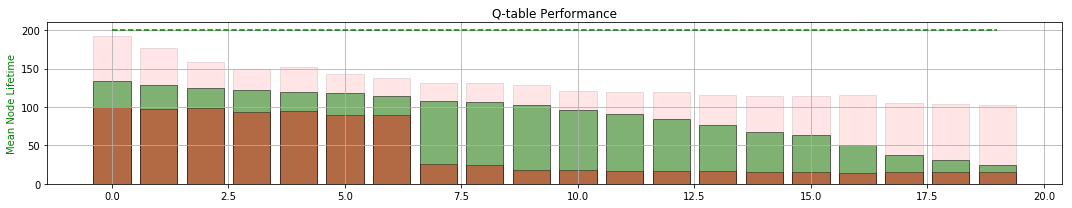

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  35994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  195.865
Validating... MEAN TIME:  94.46
Validating... MEAN TIME:  95.6
Validating... MEAN TIME:  16.165
Validating... MEAN TIME:  105.635
TRAINING TIME:0:00:28.890994


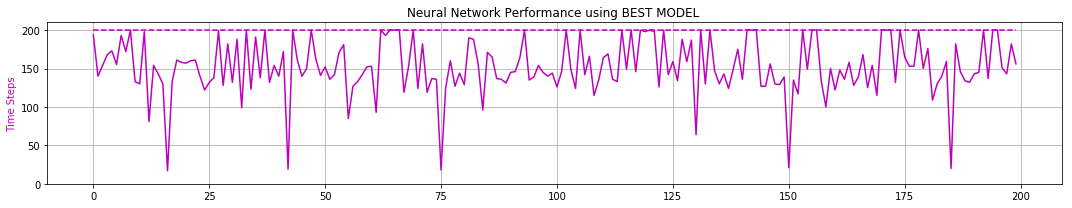

0 -max- [ 0.905  1.323  0.203  1.294  0.325]
0 -min- [-2.399 -2.904 -0.209 -1.066  0.225]

1 -max- [ 0.148  0.620  0.049  1.280  0.350]
1 -min- [-2.400 -2.948 -0.209 -0.983  0.250]

2 -max- [ 0.144  0.588  0.052  1.562  0.375]
2 -min- [-2.400 -2.924 -0.209 -1.090  0.276]

3 -max- [ 0.144  0.612  0.049  1.286  0.399]
3 -min- [-2.400 -2.980 -0.209 -1.068  0.300]

4 -max- [ 0.160  0.623  0.050  1.289  0.425]
4 -min- [-2.400 -2.973 -0.209 -1.054  0.326]

5 -max- [ 0.148  0.642  0.050  1.533  0.450]
5 -min- [-2.400 -2.976 -0.209 -1.112  0.350]

6 -max- [ 0.151  0.629  0.051  1.354  0.475]
6 -min- [-2.400 -2.969 -0.209 -1.066  0.375]

7 -max- [ 0.147  0.630  0.051  1.330  0.499]
7 -min- [-2.399 -2.972 -0.209 -1.034  0.401]

8 -max- [ 0.157  0.835  0.080  1.841  0.525]
8 -min- [-2.399 -2.978 -0.209 -1.347  0.426]

9 -max- [ 0.160  0.632  0.050  1.579  0.550]
9 -min- [-2.399 -2.969 -0.209 -1.010  0.450]

10 -max- [ 0.183  0.798  0.052  1.604  0.575]
10 -min- [-2.400 -2.975 -0.209 -1.192  0.475

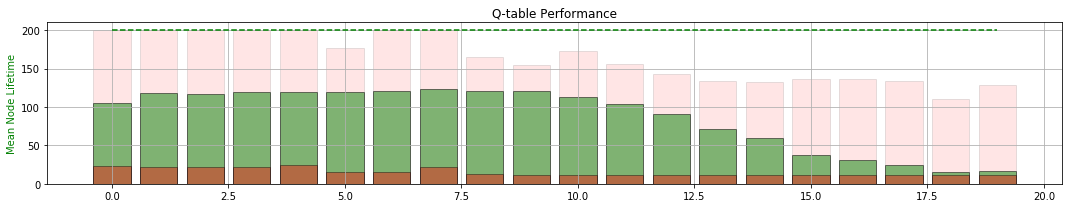

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  39938
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  125.22
Validating... MEAN TIME:  15.285
Validating... MEAN TIME:  85.995
Validating... MEAN TIME:  14.05
Validating... MEAN TIME:  14.525
TRAINING TIME:0:00:20.243502


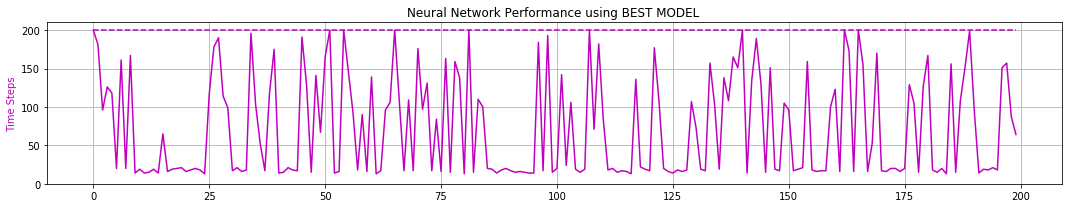

0 -max- [ 0.327  1.352  0.209  3.411  0.325]
0 -min- [-2.400 -2.431 -0.196 -1.375  0.226]

1 -max- [ 0.351  1.370  0.209  3.256  0.349]
1 -min- [-2.400 -2.583 -0.183 -1.638  0.251]

2 -max- [ 0.466  1.518  0.209  3.542  0.374]
2 -min- [-2.399 -2.557 -0.203 -1.490  0.275]

3 -max- [ 0.237  1.200  0.209  3.072  0.400]
3 -min- [-2.400 -2.499 -0.192 -1.366  0.301]

4 -max- [ 0.240  1.185  0.209  2.808  0.423]
4 -min- [-2.399 -2.600 -0.195 -1.321  0.326]

5 -max- [ 0.194  0.973  0.209  2.924  0.449]
5 -min- [-2.400 -2.580 -0.207 -1.527  0.350]

6 -max- [ 0.188  0.828  0.209  2.854  0.474]
6 -min- [-2.400 -2.782 -0.209 -1.300  0.375]

7 -max- [ 0.178  0.830  0.209  2.682  0.500]
7 -min- [-2.400 -2.815 -0.208 -1.309  0.400]

8 -max- [ 0.190  0.956  0.209  2.550  0.525]
8 -min- [-2.399 -2.617 -0.209 -1.458  0.425]

9 -max- [ 0.188  0.829  0.208  3.057  0.548]
9 -min- [-2.399 -2.616 -0.209 -1.367  0.451]

10 -max- [ 0.212  0.991  0.209  2.809  0.575]
10 -min- [-2.400 -2.796 -0.209 -1.431  0.475

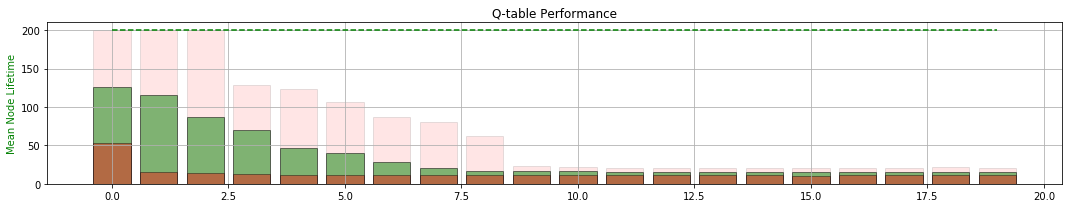

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  43917
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  159.76
Validating... MEAN TIME:  136.665
Validating... MEAN TIME:  84.79
Validating... MEAN TIME:  64.315
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:34.556191


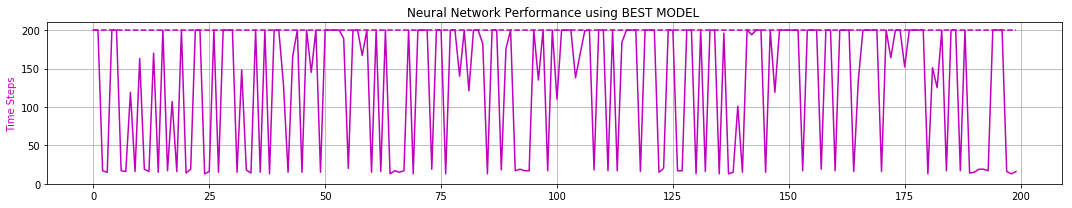

0 -max- [ 0.612  1.081  0.209  1.044  0.325]
0 -min- [-2.397 -2.913 -0.209 -1.050  0.225]

1 -max- [ 0.584  0.953  0.209  0.951  0.349]
1 -min- [-2.399 -2.912 -0.209 -1.232  0.251]

2 -max- [ 0.580  0.949  0.209  1.107  0.375]
2 -min- [-2.400 -2.912 -0.209 -1.078  0.275]

3 -max- [ 0.193  0.804  0.049  1.017  0.400]
3 -min- [-2.398 -2.878 -0.209 -1.235  0.301]

4 -max- [ 0.200  0.816  0.050  0.942  0.425]
4 -min- [-2.393 -2.932 -0.209 -1.249  0.326]

5 -max- [ 0.184  0.830  0.050  0.981  0.449]
5 -min- [-2.379 -2.956 -0.209 -1.292  0.350]

6 -max- [ 0.198  0.835  0.051  0.970  0.474]
6 -min- [-1.268 -2.017 -0.209 -1.436  0.375]

7 -max- [ 0.191  0.828  0.051  0.875  0.500]
7 -min- [-1.181 -2.039 -0.209 -1.417  0.400]

8 -max- [ 0.206  0.827  0.050  0.492  0.525]
8 -min- [-0.873 -1.835 -0.209 -1.389  0.425]

9 -max- [ 0.203  0.789  0.050  0.310  0.550]
9 -min- [-0.051 -0.186 -0.209 -1.278  0.450]

10 -max- [ 0.220  0.814  0.049  0.283  0.575]
10 -min- [-0.050 -0.241 -0.209 -1.437  0.475

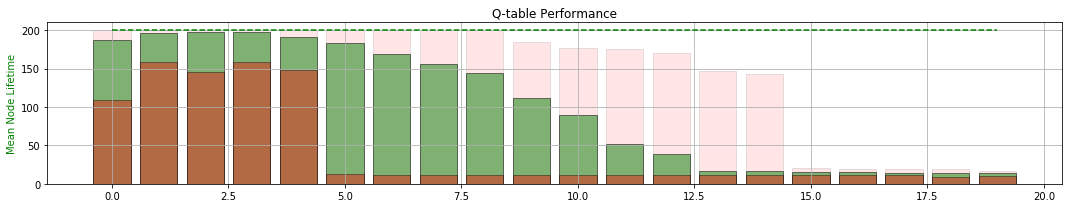

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  47036
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  13.88
Validating... MEAN TIME:  35.29
Validating... MEAN TIME:  72.08
Validating... MEAN TIME:  76.995
Validating... MEAN TIME:  13.12
TRAINING TIME:0:00:18.022680


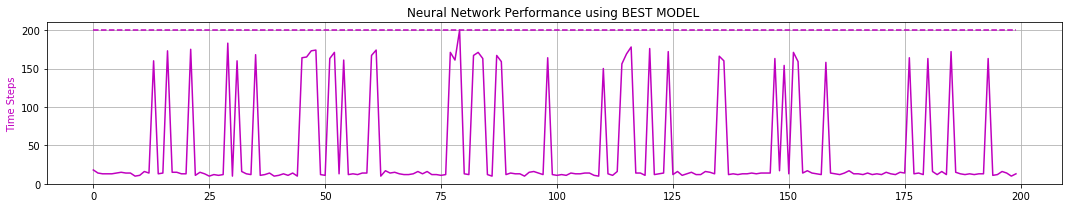

0 -max- [ 1.653  2.018  0.209  1.185  0.324]
0 -min- [-1.058 -0.781 -0.118 -1.280  0.225]

1 -max- [ 1.673  2.052  0.209  1.052  0.350]
1 -min- [-2.393 -1.851 -0.180 -1.250  0.250]

2 -max- [ 1.646  1.997  0.209  1.041  0.375]
2 -min- [-2.399 -1.850 -0.177 -1.307  0.275]

3 -max- [ 0.193  0.905  0.093  0.957  0.400]
3 -min- [-2.400 -1.852 -0.209 -1.360  0.301]

4 -max- [ 0.190  0.917  0.098  1.031  0.424]
4 -min- [-2.400 -1.990 -0.208 -1.415  0.325]

5 -max- [ 0.170  0.810  0.105  0.986  0.448]
5 -min- [-2.400 -2.191 -0.209 -1.374  0.350]

6 -max- [ 0.180  0.787  0.102  0.995  0.474]
6 -min- [-2.400 -2.189 -0.209 -1.382  0.376]

7 -max- [ 0.175  0.803  0.105  1.206  0.499]
7 -min- [-2.400 -1.975 -0.209 -1.449  0.400]

8 -max- [ 0.191  0.812  0.104  1.019  0.524]
8 -min- [-2.400 -2.196 -0.209 -1.438  0.425]

9 -max- [ 0.201  0.823  0.109  0.995  0.550]
9 -min- [-2.400 -2.075 -0.209 -1.340  0.451]

10 -max- [ 0.205  0.810  0.112  1.216  0.575]
10 -min- [-2.400 -2.177 -0.209 -1.409  0.475

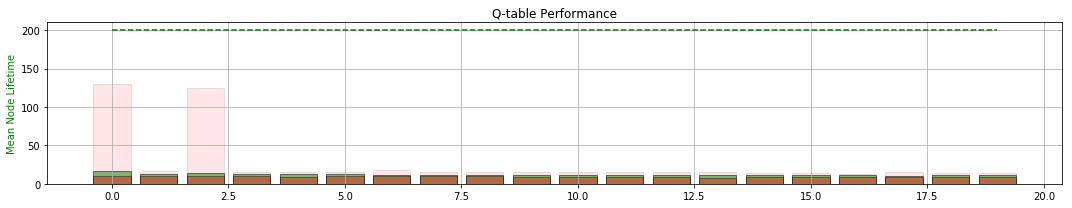

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  51036
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  11.455
Validating... MEAN TIME:  11.74
Validating... MEAN TIME:  37.18
Validating... MEAN TIME:  102.405
Validating... MEAN TIME:  29.47
TRAINING TIME:0:00:17.765239


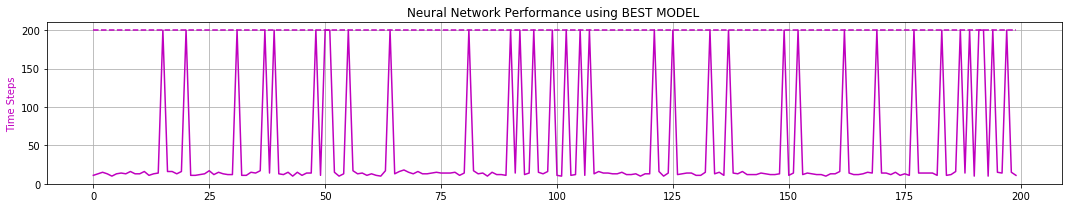

0 -max- [ 0.212  1.135  0.051  1.003  0.324]
0 -min- [-2.399 -2.234 -0.209 -1.697  0.226]

1 -max- [ 0.212  1.027  0.049  0.050  0.349]
1 -min- [-0.050 -0.050 -0.209 -1.649  0.250]

2 -max- [ 0.220  1.026  0.049  0.687  0.375]
2 -min- [-2.397 -1.869 -0.209 -1.597  0.275]

3 -max- [ 0.216  1.180  0.049  0.312  0.400]
3 -min- [-0.050 -0.229 -0.209 -1.738  0.301]

4 -max- [ 0.210  1.199  0.050  0.307  0.424]
4 -min- [-0.050 -0.239 -0.209 -1.737  0.325]

5 -max- [ 0.222  1.211  0.050  0.331  0.449]
5 -min- [-0.050 -0.237 -0.209 -1.778  0.350]

6 -max- [ 0.212  1.213  0.059  0.367  0.475]
6 -min- [-0.050 -0.228 -0.209 -1.843  0.376]

7 -max- [ 0.207  1.215  0.051  0.326  0.500]
7 -min- [-0.050 -0.221 -0.209 -1.792  0.400]

8 -max- [ 0.215  1.381  0.050  0.324  0.525]
8 -min- [-0.050 -0.238 -0.209 -1.980  0.425]

9 -max- [ 0.207  1.381  0.050  0.285  0.550]
9 -min- [-0.051 -0.179 -0.209 -2.029  0.450]

10 -max- [ 0.213  1.213  0.049  0.336  0.575]
10 -min- [-0.050 -0.243 -0.209 -1.792  0.475

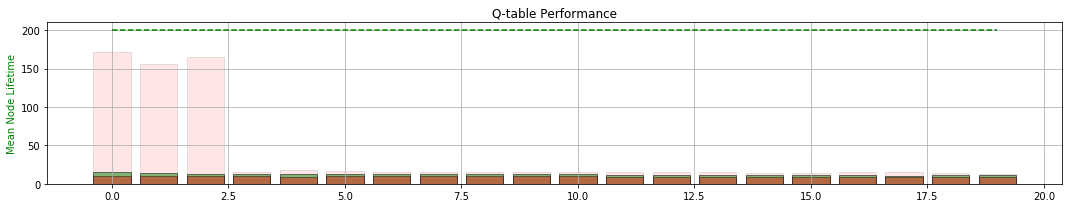

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  55036
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  37.495
Validating... MEAN TIME:  17.09
Validating... MEAN TIME:  13.505
Validating... MEAN TIME:  37.015
Validating... MEAN TIME:  9.755
TRAINING TIME:0:00:14.869113


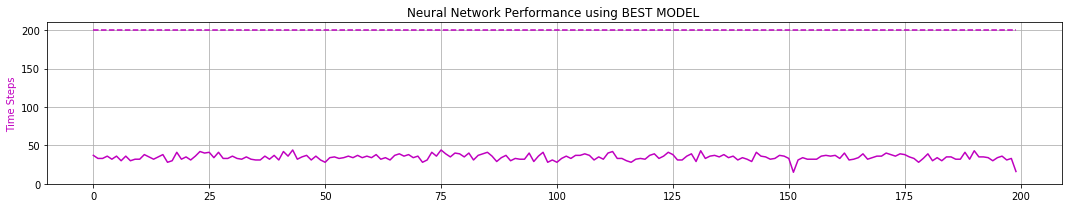

0 -max- [ 0.205  1.010  0.063  0.926  0.323]
0 -min- [-2.198 -1.331 -0.209 -1.617  0.226]

1 -max- [ 0.211  1.020  0.055  0.912  0.350]
1 -min- [-2.145 -1.341 -0.209 -1.607  0.253]

2 -max- [ 0.212  1.026  0.052  0.839  0.375]
2 -min- [-2.166 -1.348 -0.209 -1.749  0.275]

3 -max- [ 0.209  1.015  0.049  0.050  0.400]
3 -min- [-0.050 -0.050 -0.209 -1.699  0.300]

4 -max- [ 0.214  1.019  0.054  0.274  0.425]
4 -min- [-0.053 -0.197 -0.209 -1.696  0.325]

5 -max- [ 0.218  1.027  0.050  0.333  0.449]
5 -min- [-0.050 -0.224 -0.209 -1.734  0.350]

6 -max- [ 0.209  1.182  0.051  0.318  0.473]
6 -min- [-0.050 -0.241 -0.209 -1.687  0.375]

7 -max- [ 0.205  1.185  0.051  0.330  0.499]
7 -min- [-0.050 -0.237 -0.209 -1.704  0.400]

8 -max- [ 0.207  1.216  0.050  0.307  0.525]
8 -min- [-0.050 -0.216 -0.209 -1.710  0.426]

9 -max- [ 0.207  1.206  0.050  0.343  0.549]
9 -min- [-0.055 -0.238 -0.209 -1.724  0.450]

10 -max- [ 0.213  1.213  0.049  0.299  0.575]
10 -min- [-0.050 -0.242 -0.209 -1.710  0.476

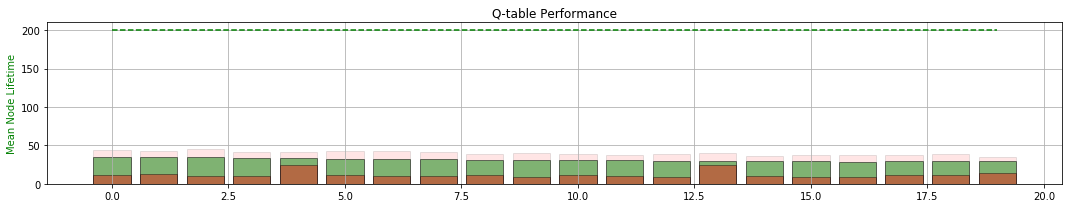

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  59036
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  10.29
Validating... MEAN TIME:  19.235
Validating... MEAN TIME:  161.245
Validating... MEAN TIME:  109.76
Validating... MEAN TIME:  132.845
TRAINING TIME:0:00:27.318494


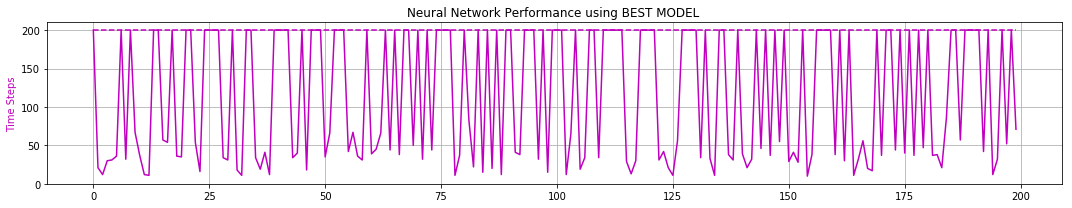

0 -max- [ 0.473  1.757  0.207  1.250  0.325]
0 -min- [-0.187 -0.812 -0.209 -1.942  0.225]

1 -max- [ 0.412  1.952  0.202  1.246  0.349]
1 -min- [-0.178 -0.828 -0.209 -2.109  0.250]

2 -max- [ 0.453  1.870  0.206  1.380  0.375]
2 -min- [-0.209 -0.828 -0.209 -1.902  0.277]

3 -max- [ 0.407  1.757  0.208  1.385  0.399]
3 -min- [-0.187 -1.021 -0.209 -2.035  0.300]

4 -max- [ 0.405  1.939  0.209  1.372  0.425]
4 -min- [-0.206 -0.956 -0.209 -1.978  0.325]

5 -max- [ 0.412  1.932  0.209  1.369  0.449]
5 -min- [-0.198 -1.022 -0.209 -1.975  0.350]

6 -max- [ 0.401  1.948  0.207  1.417  0.474]
6 -min- [-0.184 -0.969 -0.209 -2.227  0.377]

7 -max- [ 0.393  1.919  0.209  1.375  0.500]
7 -min- [-0.182 -0.995 -0.209 -2.251  0.400]

8 -max- [ 0.354  1.941  0.194  1.422  0.525]
8 -min- [-0.203 -1.007 -0.209 -2.233  0.425]

9 -max- [ 0.372  1.944  0.203  1.373  0.550]
9 -min- [-0.198 -0.993 -0.209 -2.010  0.450]

10 -max- [ 0.369  2.054  0.206  1.355  0.575]
10 -min- [-0.189 -0.974 -0.209 -2.219  0.476

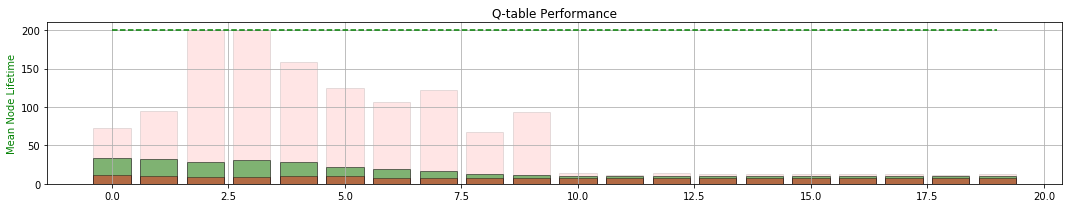

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  63034
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  29.21
Validating... MEAN TIME:  16.71
Validating... MEAN TIME:  18.025
Validating... MEAN TIME:  23.43
Validating... MEAN TIME:  27.595
TRAINING TIME:0:00:14.987415


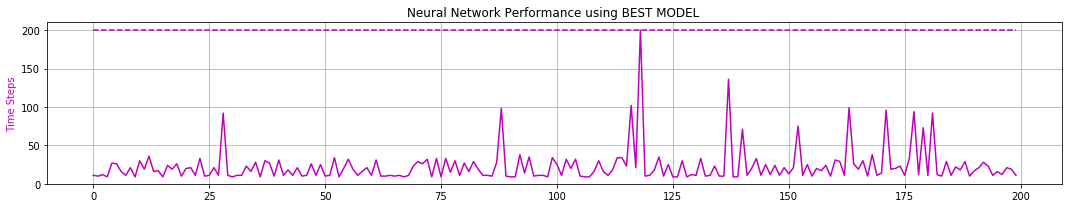

0 -max- [ 0.462  1.893  0.205  1.141  0.324]
0 -min- [-0.193 -0.785 -0.209 -1.940  0.226]

1 -max- [ 0.301  1.729  0.167  1.152  0.348]
1 -min- [-0.203 -0.813 -0.209 -2.022  0.250]

2 -max- [ 0.250  1.486  0.144  0.874  0.374]
2 -min- [-0.193 -0.628 -0.209 -2.051  0.277]

3 -max- [ 0.222  1.391  0.127  0.778  0.400]
3 -min- [-0.195 -0.628 -0.209 -2.101  0.300]

4 -max- [ 0.219  1.408  0.112  0.757  0.424]
4 -min- [-0.198 -0.629 -0.209 -2.087  0.325]

5 -max- [ 0.221  1.416  0.091  0.931  0.450]
5 -min- [-0.315 -0.721 -0.209 -2.077  0.350]

6 -max- [ 0.244  1.413  0.083  0.715  0.475]
6 -min- [-0.364 -0.794 -0.209 -2.085  0.375]

7 -max- [ 0.204  1.612  0.072  0.714  0.499]
7 -min- [-0.193 -0.626 -0.209 -2.333  0.400]

8 -max- [ 0.214  1.411  0.052  0.699  0.525]
8 -min- [-0.156 -0.626 -0.209 -2.174  0.426]

9 -max- [ 0.208  1.598  0.074  0.754  0.547]
9 -min- [-0.333 -0.631 -0.209 -2.306  0.450]

10 -max- [ 0.203  1.409  0.049  0.293  0.575]
10 -min- [-0.050 -0.244 -0.209 -2.162  0.475

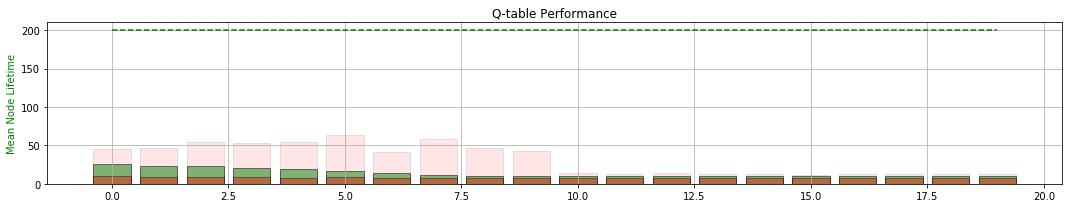

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  67034
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  32.63
Validating... MEAN TIME:  32.5
Validating... MEAN TIME:  30.385
Validating... MEAN TIME:  35.585
Validating... MEAN TIME:  30.38
TRAINING TIME:0:00:16.589704


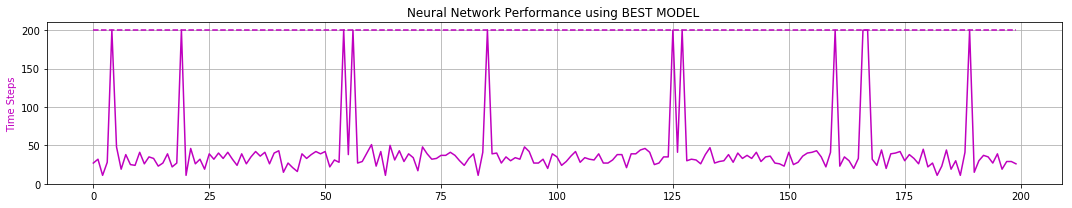

0 -max- [ 0.325  1.936  0.193  1.204  0.324]
0 -min- [-0.193 -0.817 -0.209 -2.335  0.226]

1 -max- [ 0.291  1.936  0.186  1.042  0.348]
1 -min- [-0.190 -0.633 -0.209 -2.334  0.252]

2 -max- [ 0.268  1.935  0.190  1.428  0.375]
2 -min- [-0.194 -0.818 -0.209 -2.247  0.277]

3 -max- [ 0.246  1.931  0.174  0.898  0.400]
3 -min- [-0.192 -0.627 -0.209 -2.305  0.300]

4 -max- [ 0.253  1.938  0.175  1.063  0.425]
4 -min- [-0.205 -0.774 -0.209 -2.323  0.325]

5 -max- [ 0.217  1.874  0.164  1.070  0.449]
5 -min- [-0.187 -0.827 -0.209 -2.285  0.350]

6 -max- [ 0.207  1.750  0.148  1.060  0.474]
6 -min- [-0.171 -0.762 -0.209 -2.360  0.376]

7 -max- [ 0.197  1.733  0.144  0.839  0.500]
7 -min- [-0.169 -0.810 -0.209 -2.159  0.400]

8 -max- [ 0.218  1.561  0.099  1.036  0.525]
8 -min- [-0.252 -1.006 -0.209 -2.329  0.425]

9 -max- [ 0.208  1.593  0.084  0.811  0.550]
9 -min- [-0.235 -0.815 -0.209 -2.324  0.450]

10 -max- [ 0.208  1.597  0.049  0.523  0.575]
10 -min- [-0.050 -0.437 -0.209 -2.408  0.476

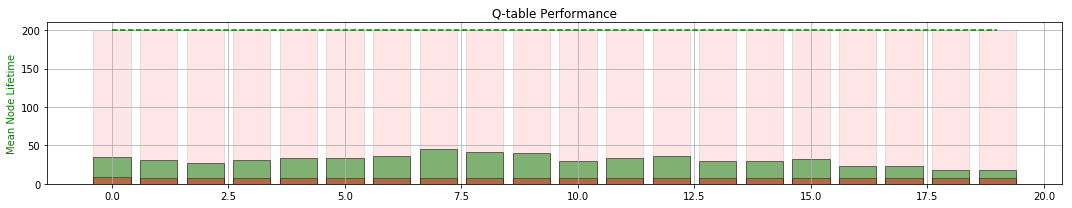

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  70778
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  37.44
Validating... MEAN TIME:  50.935
Validating... MEAN TIME:  126.18
Validating... MEAN TIME:  11.7
Validating... MEAN TIME:  177.135
TRAINING TIME:0:00:25.320091


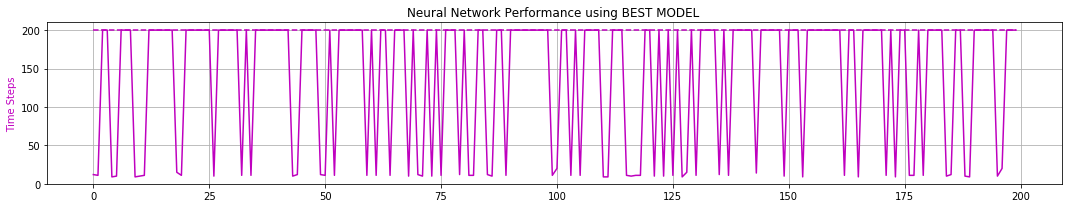

0 -max- [ 0.210  1.527  0.084  0.762  0.325]
0 -min- [-0.456 -0.716 -0.209 -2.279  0.225]

1 -max- [ 0.217  1.527  0.076  0.739  0.350]
1 -min- [-0.425 -0.629 -0.209 -2.188  0.250]

2 -max- [ 0.219  1.510  0.075  0.676  0.375]
2 -min- [-0.590 -0.622 -0.209 -2.181  0.275]

3 -max- [ 0.219  1.701  0.099  0.773  0.400]
3 -min- [-0.540 -0.631 -0.209 -2.456  0.301]

4 -max- [ 0.219  1.605  0.090  0.769  0.425]
4 -min- [-0.596 -0.627 -0.209 -2.297  0.325]

5 -max- [ 0.225  1.602  0.069  0.740  0.450]
5 -min- [-0.796 -0.801 -0.209 -2.347  0.350]

6 -max- [ 0.215  1.599  0.080  0.729  0.475]
6 -min- [-1.090 -0.971 -0.209 -2.444  0.376]

7 -max- [ 0.215  1.612  0.063  0.729  0.500]
7 -min- [-1.253 -0.973 -0.209 -2.333  0.401]

8 -max- [ 0.218  1.803  0.080  0.743  0.525]
8 -min- [-1.049 -0.813 -0.209 -2.650  0.426]

9 -max- [ 0.215  1.599  0.068  0.714  0.549]
9 -min- [-2.207 -1.687 -0.209 -2.329  0.450]

10 -max- [ 0.220  1.605  0.061  0.717  0.575]
10 -min- [-1.955 -1.502 -0.209 -2.551  0.475

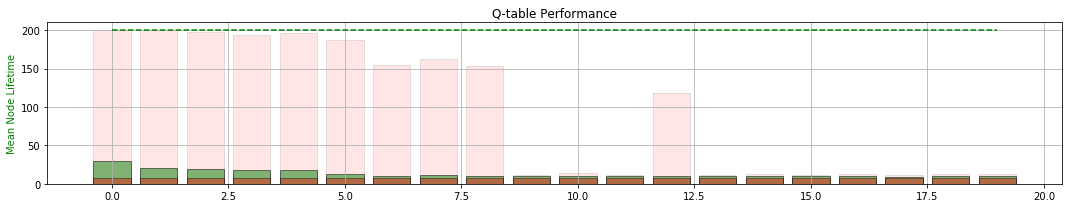

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  74768
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  38.305
Validating... MEAN TIME:  180.485
Validating... MEAN TIME:  13.265
Validating... MEAN TIME:  155.67
Validating... MEAN TIME:  121.31
TRAINING TIME:0:00:29.546524


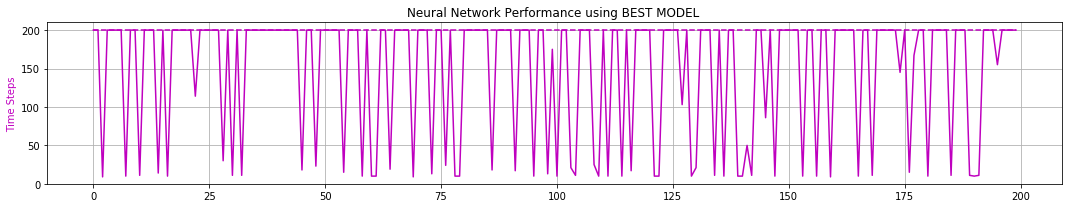

0 -max- [ 0.208  1.609  0.063  0.975  0.325]
0 -min- [-2.395 -1.896 -0.209 -2.341  0.225]

1 -max- [ 0.216  1.722  0.071  0.927  0.350]
1 -min- [-2.378 -1.698 -0.209 -2.609  0.250]

2 -max- [ 0.218  1.603  0.057  0.942  0.375]
2 -min- [-2.388 -1.880 -0.209 -2.376  0.276]

3 -max- [ 0.217  1.758  0.067  0.927  0.399]
3 -min- [-2.395 -1.717 -0.209 -2.632  0.300]

4 -max- [ 0.218  1.801  0.053  0.941  0.424]
4 -min- [-2.381 -1.719 -0.209 -2.611  0.325]

5 -max- [ 0.225  1.798  0.050  0.937  0.449]
5 -min- [-2.363 -1.541 -0.209 -2.652  0.350]

6 -max- [ 0.205  1.795  0.051  0.536  0.474]
6 -min- [-1.803 -1.150 -0.209 -2.651  0.376]

7 -max- [ 0.204  1.780  0.051  0.673  0.500]
7 -min- [-2.318 -1.516 -0.209 -2.651  0.400]

8 -max- [ 0.217  1.777  0.050  0.648  0.523]
8 -min- [-2.395 -1.706 -0.209 -2.638  0.425]

9 -max- [ 0.207  1.795  0.050  0.326  0.548]
9 -min- [-0.051 -0.225 -0.209 -2.642  0.450]

10 -max- [ 0.216  1.801  0.049  0.319  0.575]
10 -min- [-0.050 -0.177 -0.209 -2.651  0.476

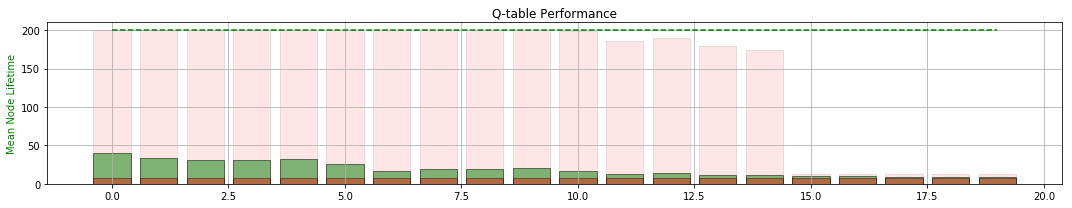

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  78664
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  177.31
Validating... MEAN TIME:  24.04
Validating... MEAN TIME:  94.865
Validating... MEAN TIME:  49.855
Validating... MEAN TIME:  26.74
TRAINING TIME:0:00:24.750267


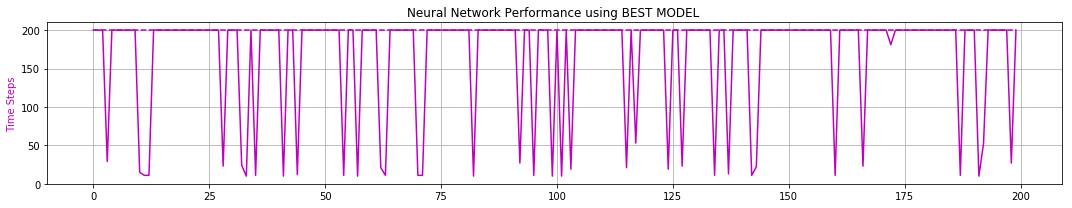

0 -max- [ 0.217  1.804  0.066  0.792  0.324]
0 -min- [-2.135 -1.539 -0.209 -2.648  0.225]

1 -max- [ 0.208  1.791  0.061  1.013  0.350]
1 -min- [-2.001 -1.710 -0.209 -2.624  0.250]

2 -max- [ 0.203  1.799  0.060  1.013  0.374]
2 -min- [-2.043 -1.540 -0.209 -2.653  0.275]

3 -max- [ 0.219  1.802  0.061  0.989  0.400]
3 -min- [-2.349 -1.730 -0.209 -2.689  0.300]

4 -max- [ 0.214  1.801  0.054  0.906  0.424]
4 -min- [-2.358 -1.704 -0.209 -2.648  0.325]

5 -max- [ 0.225  1.798  0.057  0.962  0.449]
5 -min- [-2.355 -1.698 -0.209 -2.653  0.351]

6 -max- [ 0.205  1.805  0.052  0.905  0.474]
6 -min- [-2.392 -1.857 -0.209 -2.658  0.377]

7 -max- [ 0.204  1.802  0.057  0.736  0.499]
7 -min- [-2.378 -1.694 -0.209 -2.652  0.400]

8 -max- [ 0.217  1.803  0.076  0.925  0.523]
8 -min- [-2.400 -1.884 -0.209 -2.650  0.425]

9 -max- [ 0.201  1.795  0.058  0.709  0.550]
9 -min- [-2.398 -1.872 -0.209 -2.654  0.451]

10 -max- [ 0.216  1.801  0.055  0.952  0.575]
10 -min- [-2.384 -1.894 -0.209 -2.686  0.475

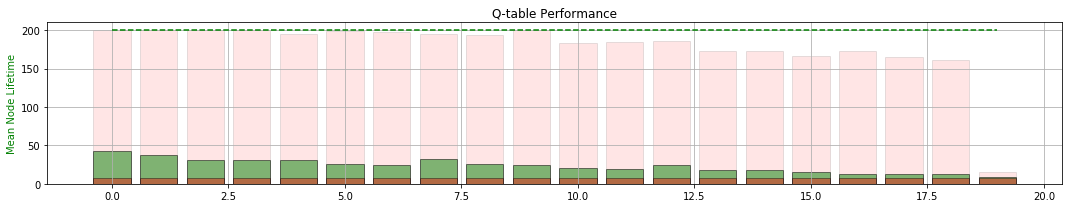

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  82651
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  107.855
Validating... MEAN TIME:  83.795
Validating... MEAN TIME:  47.47
Validating... MEAN TIME:  36.305
Validating... MEAN TIME:  19.55
TRAINING TIME:0:00:21.854798


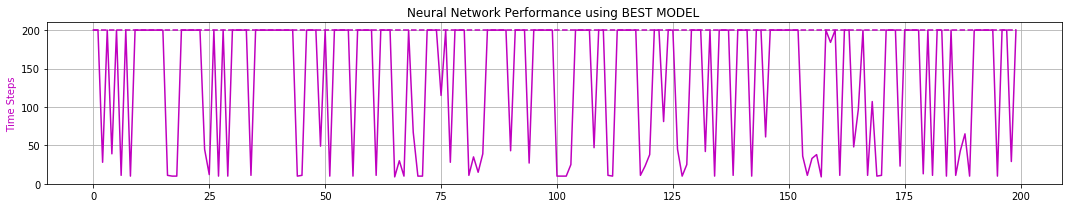

0 -max- [ 0.217  1.804  0.051  0.695  0.324]
0 -min- [-2.400 -2.058 -0.209 -2.693  0.225]

1 -max- [ 0.208  1.792  0.049  0.684  0.349]
1 -min- [-2.398 -2.054 -0.209 -2.637  0.250]

2 -max- [ 0.203  1.799  0.053  0.920  0.375]
2 -min- [-2.399 -1.883 -0.209 -2.653  0.275]

3 -max- [ 0.216  1.802  0.049  0.692  0.400]
3 -min- [-2.399 -2.057 -0.209 -2.740  0.300]

4 -max- [ 0.214  1.801  0.050  0.685  0.425]
4 -min- [-2.399 -2.056 -0.209 -2.702  0.326]

5 -max- [ 0.225  1.798  0.050  0.725  0.450]
5 -min- [-2.395 -2.054 -0.209 -2.696  0.350]

6 -max- [ 0.205  1.805  0.055  0.718  0.475]
6 -min- [-2.399 -2.056 -0.209 -2.653  0.375]

7 -max- [ 0.198  1.802  0.051  0.721  0.500]
7 -min- [-2.399 -2.066 -0.209 -2.652  0.401]

8 -max- [ 0.217  1.803  0.050  0.716  0.525]
8 -min- [-2.400 -2.061 -0.209 -2.719  0.426]

9 -max- [ 0.201  1.799  0.053  0.684  0.550]
9 -min- [-2.397 -1.883 -0.209 -2.665  0.451]

10 -max- [ 0.216  1.801  0.049  0.930  0.575]
10 -min- [-2.397 -1.873 -0.209 -2.655  0.476

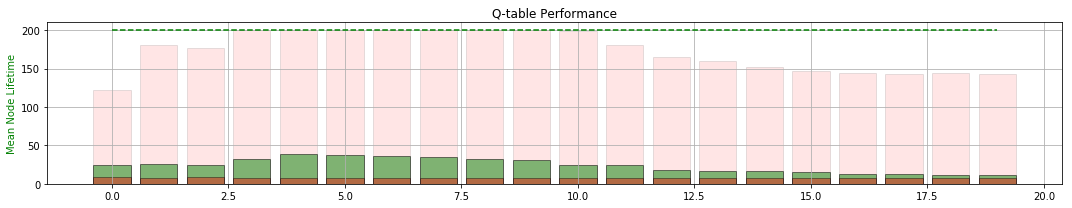

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  86606
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  23.825
Validating... MEAN TIME:  40.48
Validating... MEAN TIME:  49.055
Validating... MEAN TIME:  35.91
Validating... MEAN TIME:  45.05
TRAINING TIME:0:00:17.887090


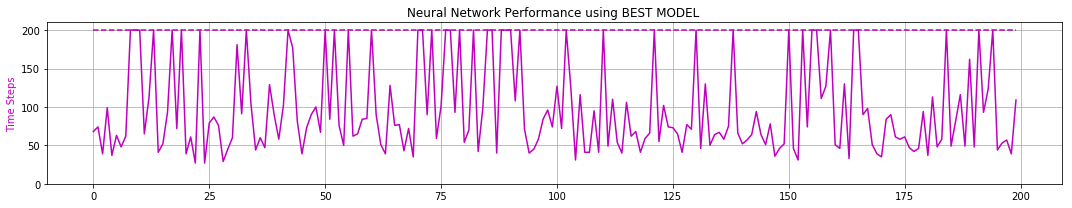

0 -max- [ 0.217  1.804  0.059  0.729  0.325]
0 -min- [-0.385 -0.619 -0.209 -2.880  0.225]

1 -max- [ 0.208  1.791  0.058  0.740  0.350]
1 -min- [-0.364 -0.618 -0.209 -2.637  0.251]

2 -max- [ 0.203  1.799  0.049  0.732  0.375]
2 -min- [-0.390 -0.624 -0.209 -2.694  0.276]

3 -max- [ 0.210  1.902  0.057  0.719  0.399]
3 -min- [-2.135 -2.243 -0.209 -2.843  0.300]

4 -max- [ 0.207  1.800  0.067  0.798  0.425]
4 -min- [-2.206 -2.186 -0.208 -2.648  0.325]

5 -max- [ 0.225  1.798  0.065  0.795  0.449]
5 -min- [-2.166 -2.256 -0.209 -2.653  0.350]

6 -max- [ 0.205  1.805  0.051  0.715  0.474]
6 -min- [-2.034 -2.230 -0.209 -2.653  0.375]

7 -max- [ 0.212  1.802  0.051  0.694  0.500]
7 -min- [-2.210 -2.239 -0.209 -2.652  0.400]

8 -max- [ 0.217  1.803  0.050  0.959  0.524]
8 -min- [-2.284 -2.436 -0.209 -2.656  0.425]

9 -max- [ 0.207  1.795  0.050  0.691  0.548]
9 -min- [-2.286 -2.428 -0.209 -2.677  0.450]

10 -max- [ 0.216  1.801  0.049  0.684  0.575]
10 -min- [-2.244 -2.437 -0.209 -2.719  0.477

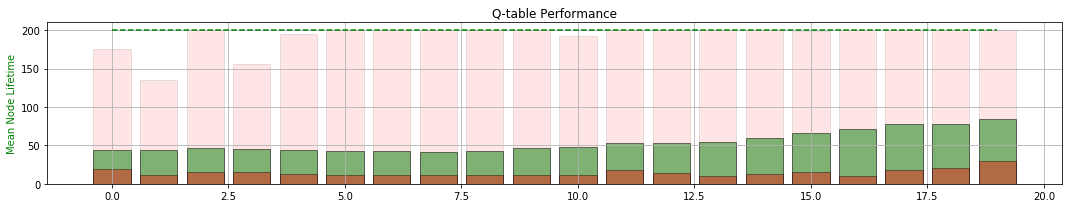

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  90578
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  42.955
Validating... MEAN TIME:  21.175
Validating... MEAN TIME:  18.175
Validating... MEAN TIME:  49.435
Validating... MEAN TIME:  66.135
TRAINING TIME:0:00:18.099279


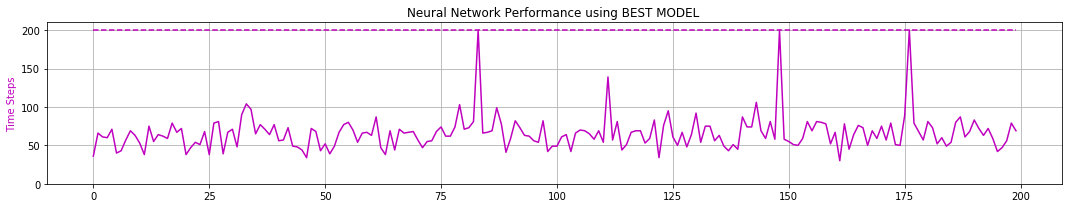

0 -max- [ 0.345  2.833  0.205  1.045  0.324]
0 -min- [-1.393 -1.496 -0.209 -3.235  0.226]

1 -max- [ 0.384  2.872  0.209  1.080  0.350]
1 -min- [-0.437 -0.773 -0.209 -3.260  0.250]

2 -max- [ 0.366  2.880  0.208  1.417  0.373]
2 -min- [-1.146 -1.092 -0.209 -3.233  0.276]

3 -max- [ 0.308  2.868  0.199  0.939  0.400]
3 -min- [-0.528 -0.614 -0.209 -3.168  0.300]

4 -max- [ 0.320  2.695  0.208  1.158  0.425]
4 -min- [-1.522 -1.633 -0.209 -3.234  0.326]

5 -max- [ 0.299  2.694  0.193  0.994  0.450]
5 -min- [-1.593 -1.685 -0.209 -3.118  0.351]

6 -max- [ 0.333  2.844  0.205  0.988  0.475]
6 -min- [-1.527 -1.657 -0.209 -3.128  0.375]

7 -max- [ 0.338  2.670  0.193  0.995  0.500]
7 -min- [-1.453 -1.662 -0.209 -3.191  0.401]

8 -max- [ 0.343  2.815  0.207  1.009  0.525]
8 -min- [-1.597 -1.688 -0.209 -3.051  0.426]

9 -max- [ 0.425  2.927  0.196  1.016  0.549]
9 -min- [-1.593 -1.679 -0.209 -3.483  0.451]

10 -max- [ 0.407  2.725  0.209  0.968  0.575]
10 -min- [-1.687 -1.868 -0.209 -3.170  0.476

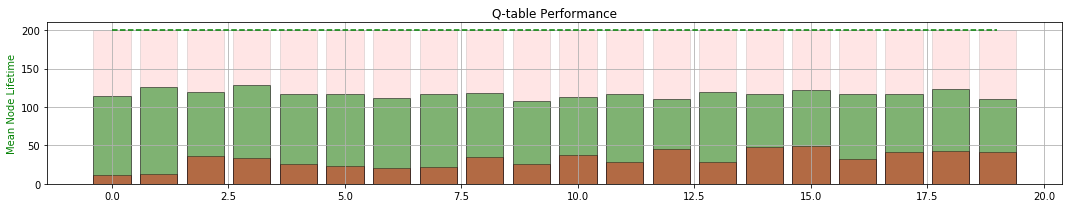

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  93675
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  122.935
Validating... MEAN TIME:  87.19
Validating... MEAN TIME:  163.84
Validating... MEAN TIME:  93.96
Validating... MEAN TIME:  38.73
TRAINING TIME:0:00:29.255402


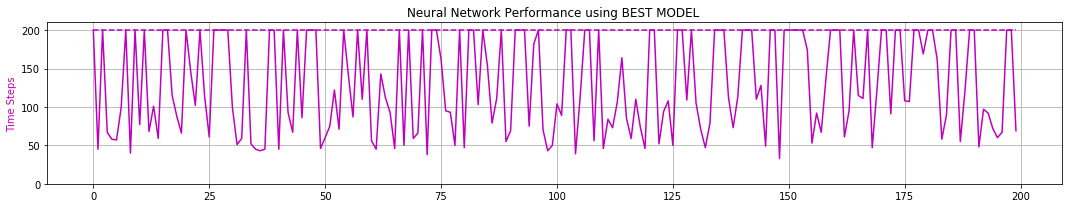

0 -max- [ 0.564  2.102  0.132  0.932  0.325]
0 -min- [-0.455 -0.762 -0.209 -2.738  0.226]

1 -max- [ 0.685  2.481  0.134  0.808  0.350]
1 -min- [-0.410 -0.629 -0.209 -3.112  0.250]

2 -max- [ 0.619  2.471  0.126  0.990  0.375]
2 -min- [-0.380 -0.797 -0.209 -3.116  0.275]

3 -max- [ 0.674  2.897  0.160  0.969  0.399]
3 -min- [-0.784 -0.767 -0.209 -3.247  0.301]

4 -max- [ 0.872  2.471  0.128  0.796  0.425]
4 -min- [-0.798 -0.947 -0.209 -3.091  0.326]

5 -max- [ 0.816  2.485  0.139  0.785  0.450]
5 -min- [-0.721 -1.136 -0.209 -3.137  0.350]

6 -max- [ 0.818  2.906  0.164  0.993  0.475]
6 -min- [-0.743 -1.136 -0.209 -3.186  0.378]

7 -max- [ 0.922  2.465  0.154  0.784  0.499]
7 -min- [-1.032 -0.981 -0.209 -2.628  0.401]

8 -max- [ 0.804  2.458  0.184  0.917  0.525]
8 -min- [-0.585 -1.175 -0.209 -2.636  0.425]

9 -max- [ 0.780  2.466  0.164  0.957  0.550]
9 -min- [-0.605 -0.991 -0.209 -2.630  0.451]

10 -max- [ 1.000  3.418  0.207  0.891  0.575]
10 -min- [-0.626 -0.966 -0.209 -3.466  0.476

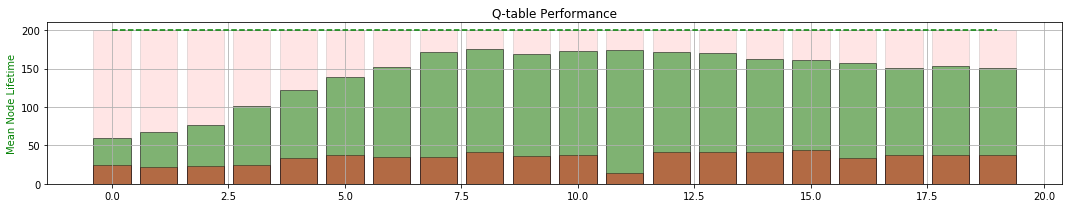

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  96864
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  172.27
Validating... MEAN TIME:  167.135
Validating... MEAN TIME:  53.545
Validating... MEAN TIME:  64.28
Validating... MEAN TIME:  61.015
TRAINING TIME:0:00:30.812520


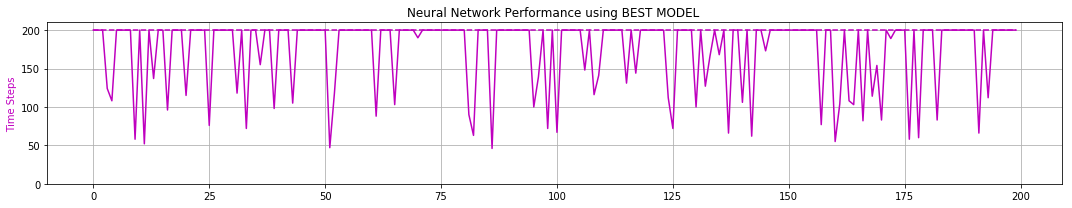

0 -max- [ 0.683  3.229  0.209  2.116  0.324]
0 -min- [-2.397 -1.856 -0.209 -3.484  0.225]

1 -max- [ 0.722  3.234  0.209  2.118  0.349]
1 -min- [-2.400 -2.077 -0.209 -3.455  0.250]

2 -max- [ 0.701  3.233  0.209  2.123  0.375]
2 -min- [-2.398 -1.877 -0.208 -3.546  0.276]

3 -max- [ 0.691  3.232  0.209  1.866  0.399]
3 -min- [-2.395 -2.065 -0.209 -3.426  0.300]

4 -max- [ 0.659  3.086  0.209  1.835  0.425]
4 -min- [-2.399 -1.884 -0.208 -3.377  0.326]

5 -max- [ 0.649  2.720  0.209  1.832  0.450]
5 -min- [-2.399 -1.975 -0.207 -2.777  0.350]

6 -max- [ 0.675  3.236  0.209  1.474  0.474]
6 -min- [-2.399 -2.046 -0.209 -3.365  0.376]

7 -max- [ 0.699  2.876  0.208  1.222  0.499]
7 -min- [-2.400 -2.050 -0.206 -2.889  0.400]

8 -max- [ 0.716  3.229  0.209  1.210  0.525]
8 -min- [-2.399 -2.050 -0.201 -3.385  0.426]

9 -max- [ 0.614  2.712  0.209  1.215  0.550]
9 -min- [-2.399 -2.067 -0.208 -2.803  0.451]

10 -max- [ 0.704  2.861  0.209  1.150  0.575]
10 -min- [-2.399 -2.064 -0.208 -2.808  0.475

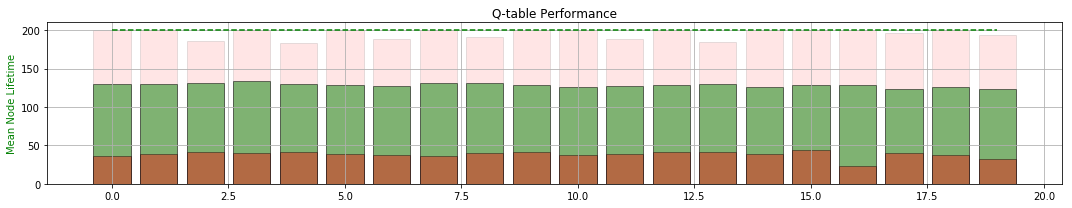

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  150.715
Validating... MEAN TIME:  145.385
Validating... MEAN TIME:  145.415
Validating... MEAN TIME:  171.41
Validating... MEAN TIME:  138.56
TRAINING TIME:0:00:39.428145


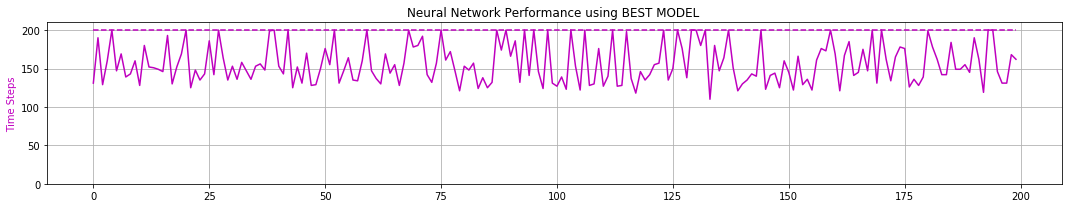

0 -max- [ 0.433  2.303  0.209  1.520  0.325]
0 -min- [-2.397 -2.411 -0.209 -2.534  0.225]

1 -max- [ 0.772  2.664  0.208  1.497  0.350]
1 -min- [-2.400 -2.416 -0.209 -2.459  0.250]

2 -max- [ 0.704  2.672  0.208  1.472  0.374]
2 -min- [-2.400 -2.388 -0.209 -2.572  0.275]

3 -max- [ 0.341  0.533  0.209  1.498  0.400]
3 -min- [-2.399 -2.426 -0.209 -0.809  0.300]

4 -max- [ 0.350  0.560  0.209  1.488  0.424]
4 -min- [-2.400 -2.414 -0.209 -1.103  0.326]

5 -max- [ 0.282  0.607  0.209  1.466  0.450]
5 -min- [-2.399 -2.510 -0.209 -1.040  0.350]

6 -max- [ 0.219  0.550  0.209  1.474  0.475]
6 -min- [-2.400 -2.411 -0.209 -1.021  0.375]

7 -max- [ 0.206  0.557  0.209  1.528  0.500]
7 -min- [-2.400 -2.423 -0.209 -0.806  0.400]

8 -max- [ 0.219  0.546  0.205  1.223  0.525]
8 -min- [-2.400 -2.563 -0.209 -0.879  0.426]

9 -max- [ 0.415  0.563  0.208  1.219  0.550]
9 -min- [-2.400 -2.600 -0.209 -0.890  0.451]

10 -max- [ 0.469  0.556  0.209  1.159  0.575]
10 -min- [-2.400 -2.416 -0.209 -0.824  0.476

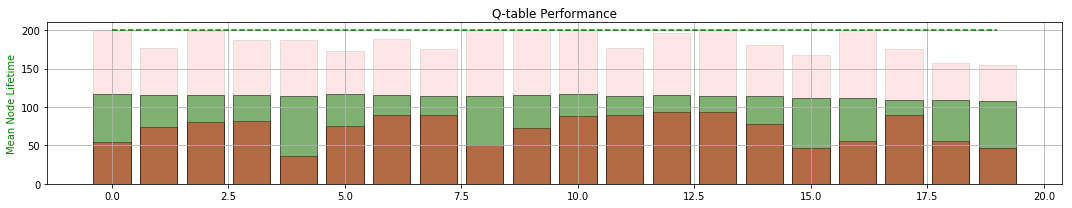

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  153.025
Validating... MEAN TIME:  120.405
Validating... MEAN TIME:  141.425
Validating... MEAN TIME:  112.67
Validating... MEAN TIME:  168.665
TRAINING TIME:0:00:37.821074


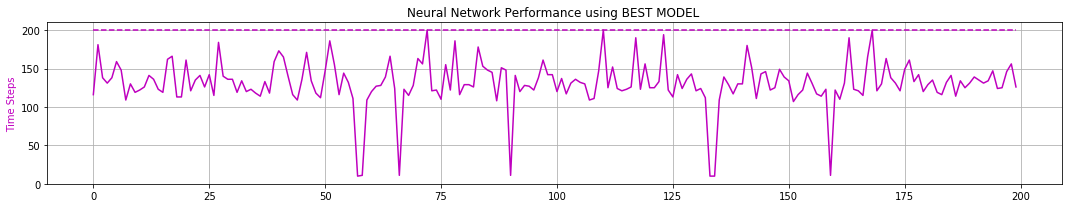

0 -max- [ 0.654  2.541  0.126  0.758  0.323]
0 -min- [-2.287 -2.510 -0.209 -2.927  0.226]

1 -max- [ 0.645  2.541  0.119  0.780  0.349]
1 -min- [-2.379 -2.526 -0.209 -2.959  0.250]

2 -max- [ 0.670  2.500  0.110  0.873  0.375]
2 -min- [-2.385 -2.554 -0.209 -2.865  0.275]

3 -max- [ 0.645  2.525  0.125  0.701  0.399]
3 -min- [-2.377 -2.684 -0.209 -2.936  0.300]

4 -max- [ 0.706  2.717  0.112  0.708  0.424]
4 -min- [-2.368 -2.590 -0.209 -3.113  0.325]

5 -max- [ 0.901  2.698  0.128  0.832  0.450]
5 -min- [-2.360 -2.582 -0.209 -2.972  0.351]

6 -max- [ 0.918  3.092  0.164  0.789  0.474]
6 -min- [-2.395 -2.745 -0.209 -3.182  0.375]

7 -max- [ 0.842  2.893  0.120  0.668  0.499]
7 -min- [-2.375 -2.595 -0.209 -3.071  0.400]

8 -max- [ 0.968  3.241  0.170  0.876  0.524]
8 -min- [-2.389 -2.707 -0.209 -3.438  0.425]

9 -max- [ 0.912  3.100  0.160  0.852  0.550]
9 -min- [-2.315 -2.603 -0.209 -3.144  0.450]

10 -max- [ 0.908  3.078  0.146  0.752  0.574]
10 -min- [-2.383 -2.697 -0.209 -3.318  0.475

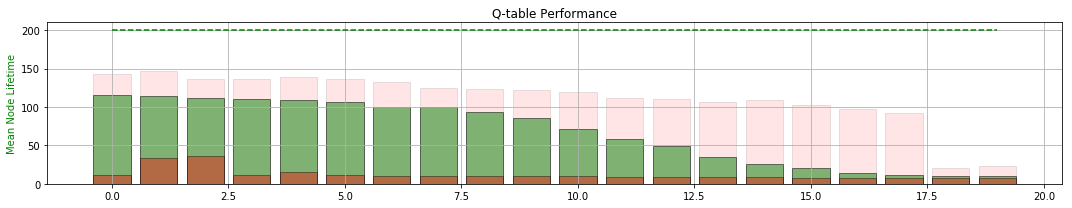

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  172.02
Validating... MEAN TIME:  64.925
Validating... MEAN TIME:  98.31
Validating... MEAN TIME:  116.91
Validating... MEAN TIME:  110.255
TRAINING TIME:0:00:32.722053


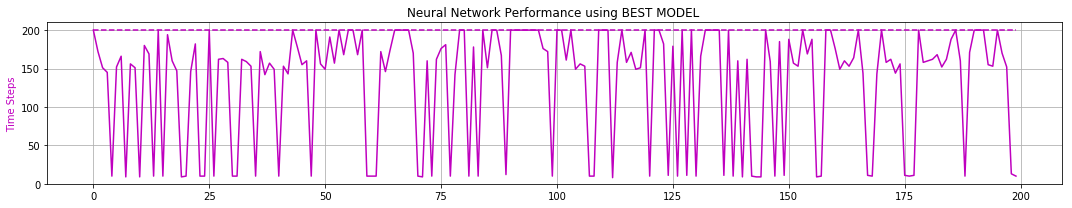

0 -max- [ 0.195  1.791  0.051  0.913  0.325]
0 -min- [-2.400 -2.779 -0.206 -2.621  0.226]

1 -max- [ 0.166  0.752  0.049  0.966  0.349]
1 -min- [-2.400 -2.787 -0.209 -1.187  0.250]

2 -max- [ 0.140  0.776  0.049  0.939  0.374]
2 -min- [-2.400 -2.762 -0.205 -1.191  0.275]

3 -max- [ 0.169  1.767  0.049  0.954  0.400]
3 -min- [-2.400 -2.776 -0.208 -2.632  0.300]

4 -max- [ 0.162  1.787  0.050  0.918  0.424]
4 -min- [-2.400 -2.777 -0.209 -2.625  0.325]

5 -max- [ 0.154  1.531  0.050  0.955  0.450]
5 -min- [-2.400 -2.766 -0.209 -2.305  0.350]

6 -max- [ 0.154  1.773  0.059  0.894  0.475]
6 -min- [-2.400 -2.780 -0.209 -2.709  0.375]

7 -max- [ 0.190  1.781  0.051  0.987  0.499]
7 -min- [-2.400 -2.792 -0.209 -2.651  0.400]

8 -max- [ 0.217  1.757  0.050  0.924  0.525]
8 -min- [-2.399 -2.929 -0.209 -2.584  0.426]

9 -max- [ 0.186  1.787  0.050  0.947  0.550]
9 -min- [-2.400 -2.797 -0.209 -2.674  0.451]

10 -max- [ 0.198  1.801  0.049  0.918  0.575]
10 -min- [-2.400 -2.778 -0.209 -2.719  0.476

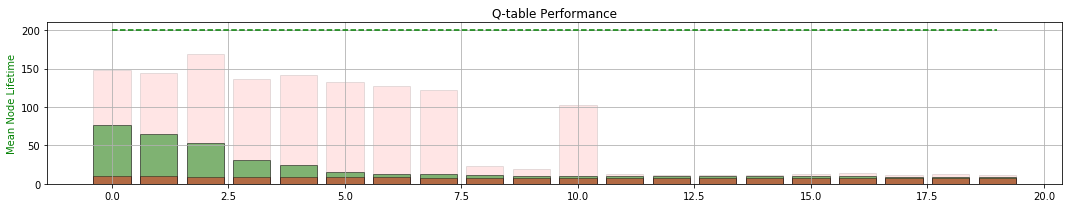

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  124.905
Validating... MEAN TIME:  199.56
Validating... MEAN TIME:  199.65
Validating... MEAN TIME:  155.635
Validating... MEAN TIME:  199.77
TRAINING TIME:0:00:44.723157


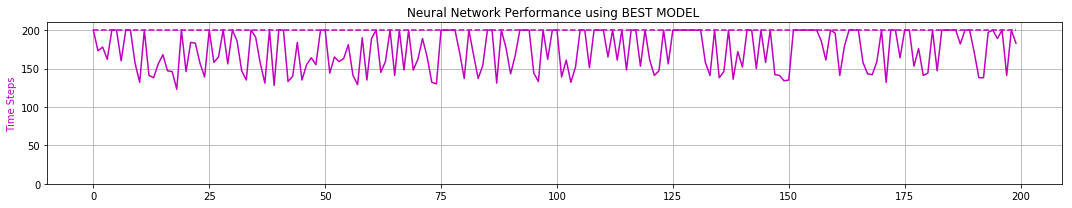

0 -max- [ 0.218  1.799  0.138  1.029  0.324]
0 -min- [-2.400 -2.092 -0.209 -2.642  0.227]

1 -max- [ 0.216  1.606  0.133  1.116  0.350]
1 -min- [-2.400 -2.095 -0.209 -2.334  0.250]

2 -max- [ 0.218  1.771  0.151  1.168  0.375]
2 -min- [-2.400 -2.094 -0.209 -2.650  0.276]

3 -max- [ 0.217  1.611  0.139  1.040  0.400]
3 -min- [-2.400 -2.093 -0.209 -2.424  0.300]

4 -max- [ 0.218  1.797  0.122  0.983  0.425]
4 -min- [-2.399 -2.081 -0.209 -2.646  0.325]

5 -max- [ 0.217  1.791  0.107  0.919  0.446]
5 -min- [-2.399 -1.898 -0.209 -2.652  0.350]

6 -max- [ 0.205  1.795  0.109  0.935  0.475]
6 -min- [-2.387 -1.842 -0.209 -2.653  0.375]

7 -max- [ 0.204  1.802  0.103  0.902  0.499]
7 -min- [-2.395 -1.898 -0.209 -2.652  0.401]

8 -max- [ 0.208  1.803  0.050  0.267  0.525]
8 -min- [-0.050 -0.403 -0.209 -2.650  0.425]

9 -max- [ 0.207  1.795  0.050  0.328  0.550]
9 -min- [-0.051 -0.413 -0.209 -2.654  0.450]

10 -max- [ 0.216  1.801  0.103  0.882  0.575]
10 -min- [-2.384 -1.906 -0.209 -2.768  0.476

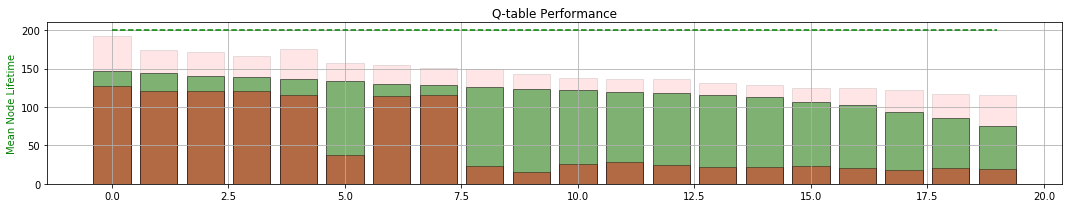

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  142.27
Validating... MEAN TIME:  152.91
Validating... MEAN TIME:  157.09
Validating... MEAN TIME:  139.925
Validating... MEAN TIME:  143.915
TRAINING TIME:0:00:39.250639


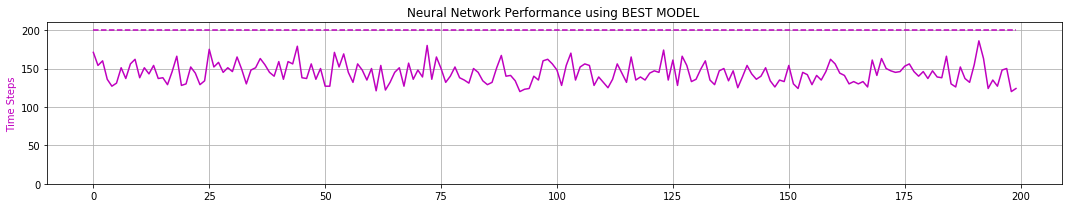

0 -max- [ 0.149  0.619  0.107  1.330  0.325]
0 -min- [-2.400 -2.102 -0.157 -0.928  0.226]

1 -max- [ 0.153  0.584  0.108  1.324  0.350]
1 -min- [-2.400 -2.194 -0.166 -0.960  0.251]

2 -max- [ 0.141  0.624  0.091  1.322  0.374]
2 -min- [-2.400 -2.288 -0.175 -0.920  0.276]

3 -max- [ 0.144  0.631  0.083  1.274  0.400]
3 -min- [-2.400 -2.105 -0.197 -0.983  0.300]

4 -max- [ 0.166  0.619  0.093  1.558  0.424]
4 -min- [-2.400 -2.478 -0.181 -1.080  0.325]

5 -max- [ 0.150  0.753  0.092  1.626  0.450]
5 -min- [-2.399 -2.485 -0.209 -1.291  0.350]

6 -max- [ 0.144  0.629  0.065  1.310  0.475]
6 -min- [-2.400 -2.266 -0.183 -1.044  0.376]

7 -max- [ 0.143  0.615  0.069  1.275  0.500]
7 -min- [-2.400 -2.286 -0.186 -1.033  0.400]

8 -max- [ 0.164  0.632  0.083  1.797  0.525]
8 -min- [-2.400 -2.825 -0.208 -1.138  0.425]

9 -max- [ 0.167  0.636  0.074  1.322  0.550]
9 -min- [-2.400 -2.286 -0.208 -1.113  0.450]

10 -max- [ 0.187  0.623  0.079  1.337  0.575]
10 -min- [-2.400 -2.290 -0.208 -1.041  0.475

In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = 0.5 + np.random.uniform(-0.3,0.3)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = 0.5 + np.random.uniform(-0.3,0.3)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    for node_id in range(NO_OF_NODES):
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        # CREATE STATE COMBINATIONS
        ###############################################

        
        ###############################################
    node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                        [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                        [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

    # SAVE QFILE
    node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5042.0
Total Serial Timesteps   :  7361885.0
Speed-up                 :  1460.11


In [21]:
pool.close()
pool.join()